In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor

df_model = pd.read_csv('../data/pet_adoption_model.csv')
print(f"✅ Dataset cargado: {df_model.shape[0]:,} filas")

✅ Dataset cargado: 52,535 filas


In [6]:
FEATURES = ['AnimalType', 'Sex', 'IntakeType', 'IntakeCondition',
            'AgeInDays', 'AgeGroup', 'breed_type', 'Breed_grouped', 'Color_grouped']
TARGET = 'TimeInShelterDays_log'

X = df_model[FEATURES].copy()
y = df_model[TARGET].copy()

ohe_cols       = ['AnimalType', 'Sex', 'IntakeType', 'IntakeCondition',
                  'breed_type', 'Breed_grouped', 'Color_grouped']
ordinal_col    = ['AgeGroup']
numerical_cols = ['AgeInDays']
orden_edad     = [['Cachorro (<6m)', 'Joven (6m-1a)', 'Adulto joven (1-3a)',
                   'Adulto (3-7a)', 'Senior (>7a)']]

preprocessor = ColumnTransformer(transformers=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_cols),
    ("ord", OrdinalEncoder(categories=orden_edad,
                           handle_unknown="use_encoded_value",
                           unknown_value=-1), ordinal_col),
    ("num", StandardScaler(), numerical_cols)
], remainder='drop')

print("✅ Preprocesador definido")

✅ Preprocesador definido


In [7]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])
print("✅ Pipeline XGBoost definido")

✅ Pipeline XGBoost definido


In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

print("⏳ Ejecutando K-Fold (k=5)... puede tardar unos minutos")

rmse_scores = -cross_val_score(pipeline, X, y, cv=kf, scoring=rmse_scorer)
r2_scores   =  cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
mae_scores  = -cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')

print("\n📊 RESULTADOS POR FOLD:")
print(f"\n  {'Fold':>5} {'RMSE':>10} {'R²':>10} {'MAE':>10}")
print(f"  {'-'*38}")
for i, (rmse, r2, mae) in enumerate(zip(rmse_scores, r2_scores, mae_scores), 1):
    print(f"  {i:>5} {rmse:>10.4f} {r2:>10.4f} {mae:>10.4f}")

print(f"\n📊 RESUMEN:")
print(f"  RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
print(f"  R²:   {r2_scores.mean():.4f}  ± {r2_scores.std():.4f}")
print(f"  MAE:  {mae_scores.mean():.4f}  ± {mae_scores.std():.4f}")

print(f"\n📊 COMPARATIVA con validación simple (#17):")
print(f"  {'':25} {'KFold CV':>10} {'Val #17':>10}")
print(f"  {'-'*46}")
print(f"  {'RMSE':<25} {rmse_scores.mean():>10.4f} {'1.0711':>10}")
print(f"  {'R²':<25} {r2_scores.mean():>10.4f} {'0.2540':>10}")

⏳ Ejecutando K-Fold (k=5)... puede tardar unos minutos

📊 RESULTADOS POR FOLD:

   Fold       RMSE         R²        MAE
  --------------------------------------
      1     1.0820     0.2449     0.8513
      2     1.0714     0.2507     0.8472
      3     1.0719     0.2617     0.8489
      4     1.0818     0.2484     0.8526
      5     1.0857     0.2478     0.8549

📊 RESUMEN:
  RMSE: 1.0786 ± 0.0058
  R²:   0.2507  ± 0.0058
  MAE:  0.8510  ± 0.0027

📊 COMPARATIVA con validación simple (#17):
                              KFold CV    Val #17
  ----------------------------------------------
  RMSE                          1.0786     1.0711
  R²                            0.2507     0.2540


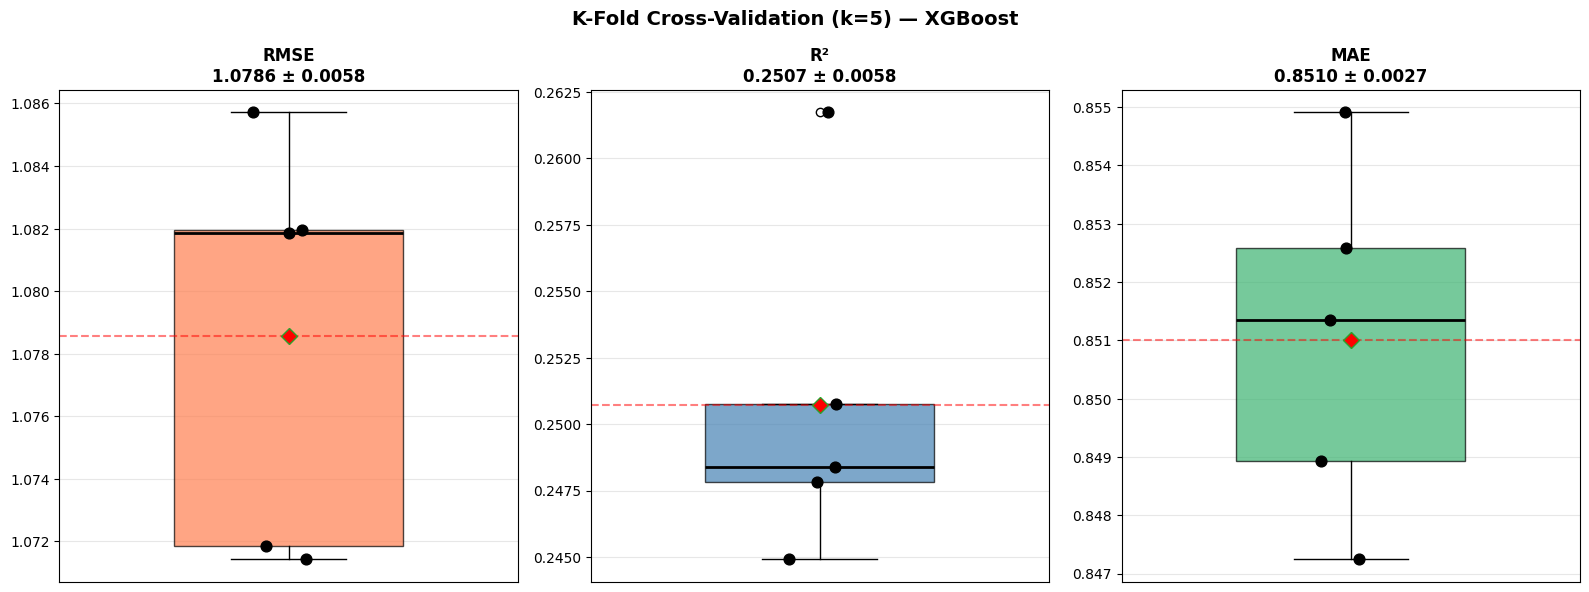

💾 Resultados guardados en cv_results.csv


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

metricas = {'RMSE': rmse_scores, 'R²': r2_scores, 'MAE': mae_scores}
colores  = ['coral', 'steelblue', 'mediumseagreen']

for ax, (nombre, scores), color in zip(axes, metricas.items(), colores):
    ax.boxplot(scores, patch_artist=True, widths=0.5,
               boxprops=dict(facecolor=color, alpha=0.7),
               medianprops=dict(color='black', linewidth=2),
               showmeans=True,
               meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    x_jitter = np.random.normal(1, 0.04, size=len(scores))
    ax.scatter(x_jitter, scores, color='black', s=60, zorder=5)
    ax.axhline(scores.mean(), color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{nombre}\n{scores.mean():.4f} ± {scores.std():.4f}', fontweight='bold')
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('K-Fold Cross-Validation (k=5) — XGBoost', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Guardar resultados
pd.DataFrame({
    'fold': range(1, 6),
    'rmse': rmse_scores,
    'r2':   r2_scores,
    'mae':  mae_scores
}).to_csv('../data/cv_results.csv', index=False)
print("💾 Resultados guardados en cv_results.csv")